In [ ]:
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


**PLOT FOOD & IMAGE METADATA**

Mounted at /content/drive
⏳ Đang load dữ liệu...
✅ Đã load tổng cộng: 738 ảnh.
   - Cha Ca: 200
   - Tofu:   209
   - Suon:   329


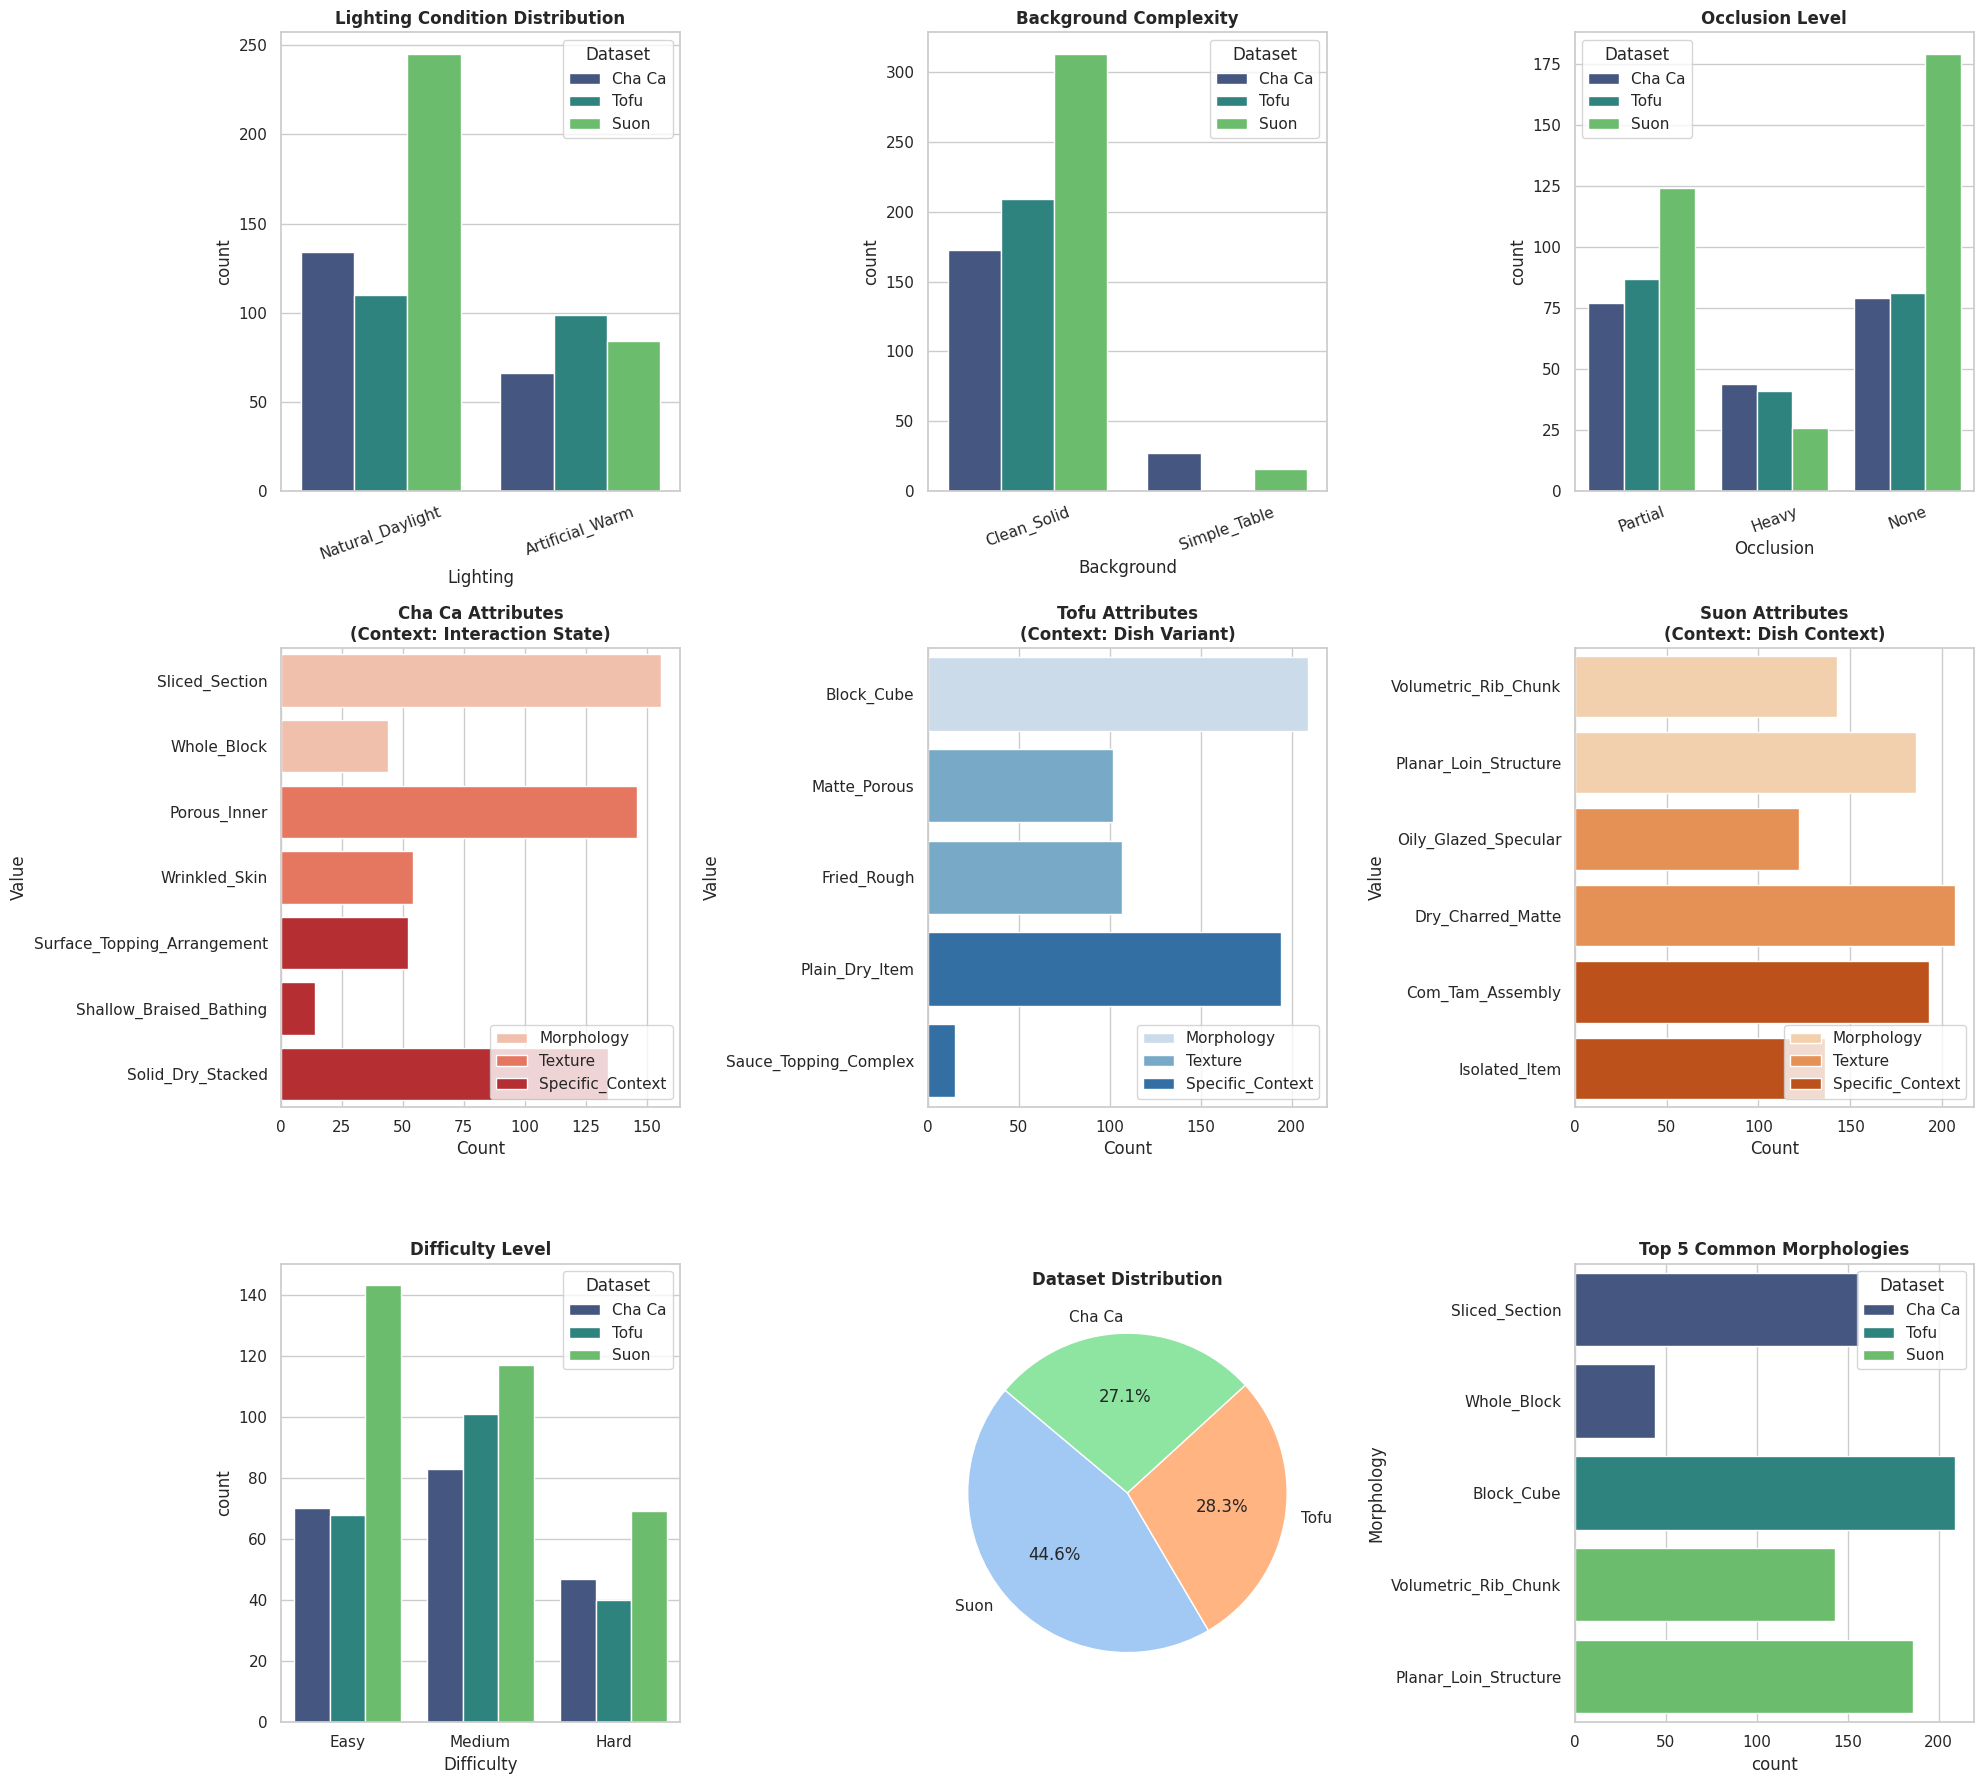

In [ ]:
def load_and_normalize(file_path, dish_type):
    """
    Đọc file JSON và map các key khác nhau về chuẩn chung DataFrame
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"ERROR: Không tìm thấy file {file_path}")
        return pd.DataFrame()
    except json.JSONDecodeError:
        print(f"ERROR: Lỗi format JSON tại {file_path}")
        return pd.DataFrame()

    normalized_list = []

    for entry in data:
        img_attrs = entry.get('image_attributes', {})
        food_attrs = entry.get('food_attributes', {})

        row = {
            'Dataset': dish_type,
            'Filename': entry.get('id_anh', 'Unknown'),
            'Lighting': img_attrs.get('lighting_condition', 'Unknown'),
            'Background': img_attrs.get('background_complexity', 'Unknown'),
            'Occlusion': img_attrs.get('occlusion_level', 'Unknown'),
            'Difficulty': img_attrs.get('difficulty_level', 'Unknown'),
            'Texture': food_attrs.get('surface_texture', 'Unknown')
        }

        raw_morph = food_attrs.get('morphology', 'Unknown')

        if dish_type == 'Suon':
            if isinstance(raw_morph, dict):
                row['Morphology'] = raw_morph.get('category', 'Unknown')
            else:
                row['Morphology'] = str(raw_morph)
        else:
            row['Morphology'] = raw_morph if isinstance(raw_morph, str) else str(raw_morph)

        if dish_type == 'Cha Ca':
            row['Specific_Context'] = food_attrs.get('interaction_state', 'Unknown')
        elif dish_type == 'Tofu':
            row['Specific_Context'] = food_attrs.get('dish_variant', 'Unknown')
        elif dish_type == 'Suon':
            row['Specific_Context'] = food_attrs.get('dish_context', 'Unknown')
        else:
            row['Specific_Context'] = 'Unknown'

        normalized_list.append(row)

    return pd.DataFrame(normalized_list)

path_chaca = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/cha_ca_v2_final_labeled_new.json'
path_tofu  = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/tofu_final_labeled_new.json'
path_suon  = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/suon_v2_filter_final.json'

print("⏳ Đang load dữ liệu...")
df_chaca = load_and_normalize(path_chaca, 'Cha Ca')
df_tofu = load_and_normalize(path_tofu, 'Tofu')
df_suon = load_and_normalize(path_suon, 'Suon')

df_combined = pd.concat([df_chaca, df_tofu, df_suon], ignore_index=True)

if df_combined.empty:
    print("Không có dữ liệu để vẽ biểu đồ.")
else:
    print(f"Đã load tổng cộng: {len(df_combined)} ảnh.")
    print(f"   - Cha Ca: {len(df_chaca)}")
    print(f"   - Tofu:   {len(df_tofu)}")
    print(f"   - Suon:   {len(df_suon)}")

    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(20, 18))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    ax1 = plt.subplot(3, 3, 1)
    sns.countplot(data=df_combined, x='Lighting', hue='Dataset', ax=ax1, palette='viridis')
    ax1.set_title('Lighting Condition Distribution', fontweight='bold')
    ax1.tick_params(axis='x', rotation=20)

    ax2 = plt.subplot(3, 3, 2)
    sns.countplot(data=df_combined, x='Background', hue='Dataset', ax=ax2, palette='viridis')
    ax2.set_title('Background Complexity', fontweight='bold')
    ax2.tick_params(axis='x', rotation=20)

    ax3 = plt.subplot(3, 3, 3)
    sns.countplot(data=df_combined, x='Occlusion', hue='Dataset', ax=ax3, palette='viridis')
    ax3.set_title('Occlusion Level', fontweight='bold')
    ax3.tick_params(axis='x', rotation=20)

    def plot_food_attributes(df, title, ax, color_palette):
        if df.empty: return
        cols = ['Morphology', 'Texture', 'Specific_Context']
        df_melt = df[cols].melt(var_name='Attribute', value_name='Value')

        df_melt = df_melt[df_melt['Value'] != 'Unknown']

        if not df_melt.empty:
            sns.countplot(data=df_melt, y='Value', hue='Attribute', ax=ax, dodge=False, palette=color_palette)
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Count")
            ax.legend(loc='lower right')

    ax4 = plt.subplot(3, 3, 4)
    plot_food_attributes(df_chaca, 'Cha Ca Attributes\n(Context: Interaction State)', ax4, 'Reds')

    ax5 = plt.subplot(3, 3, 5)
    plot_food_attributes(df_tofu, 'Tofu Attributes\n(Context: Dish Variant)', ax5, 'Blues')

    ax6 = plt.subplot(3, 3, 6)
    plot_food_attributes(df_suon, 'Suon Attributes\n(Context: Dish Context)', ax6, 'Oranges')

    ax7 = plt.subplot(3, 3, 7)
    order_lvl = ['Easy', 'Medium', 'Hard']
    existing_levels = [l for l in order_lvl if l in df_combined['Difficulty'].unique()]

    sns.countplot(data=df_combined, x='Difficulty', hue='Dataset', ax=ax7, order=existing_levels, palette='viridis')
    ax7.set_title('Difficulty Level', fontweight='bold')

    ax8 = plt.subplot(3, 3, 8)

    counts = df_combined['Dataset'].value_counts()
    ax8.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    ax8.set_title('Dataset Distribution', fontweight='bold')

    ax9 = plt.subplot(3, 3, 9)

    top_morph = df_combined['Morphology'].value_counts().head(5).index
    sns.countplot(data=df_combined[df_combined['Morphology'].isin(top_morph)],
                  y='Morphology', hue='Dataset', ax=ax9, palette='viridis')
    ax9.set_title('Top 5 Common Morphologies', fontweight='bold')

    plt.tight_layout()
    plt.savefig('food_dataset_analysis_final.png')
    plt.show()

**PLOT SUB CLASSES ATTRIBUTES**

Mounted at /content/drive
⏳ Đang xử lý dữ liệu...

🎨 1. Đang vẽ biểu đồ thuộc tính vật lý (Morphology, Texture, Context)...


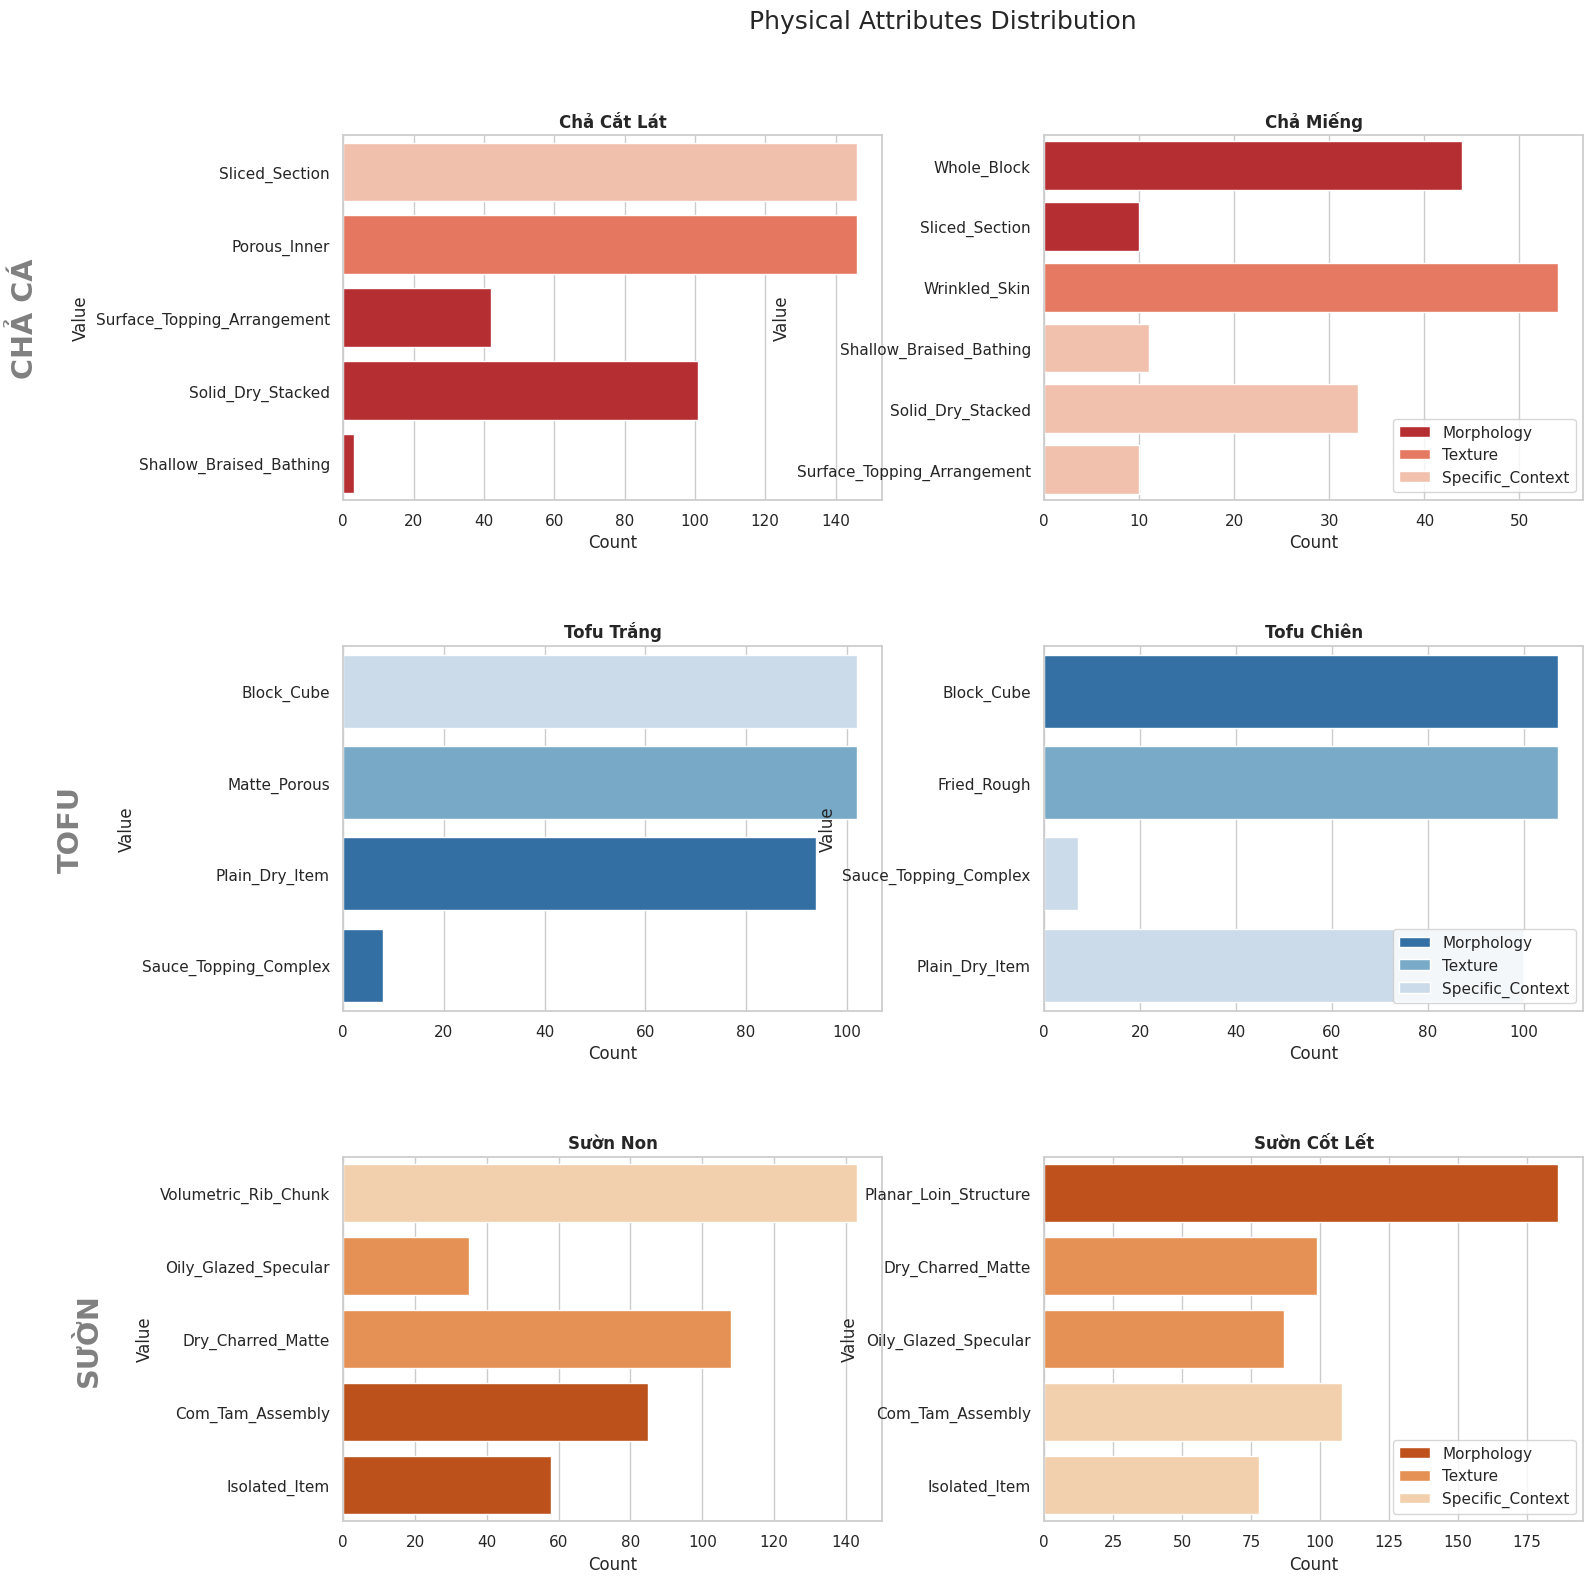


🎨 2. Đang vẽ biểu đồ độ khó (Difficulty Level)...


/tmp/ipython-input-2546359643.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_diff, x='Difficulty', ax=ax, order=diff_order, palette=config['color'])
/tmp/ipython-input-2546359643.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_diff, x='Difficulty', ax=ax, order=diff_order, palette=config['color'])
/tmp/ipython-input-2546359643.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_diff, x='Difficulty', ax=ax, order=diff_order, palette=config['color'])
/tmp/ipython-input-2546359643.py:165: FutureWarni

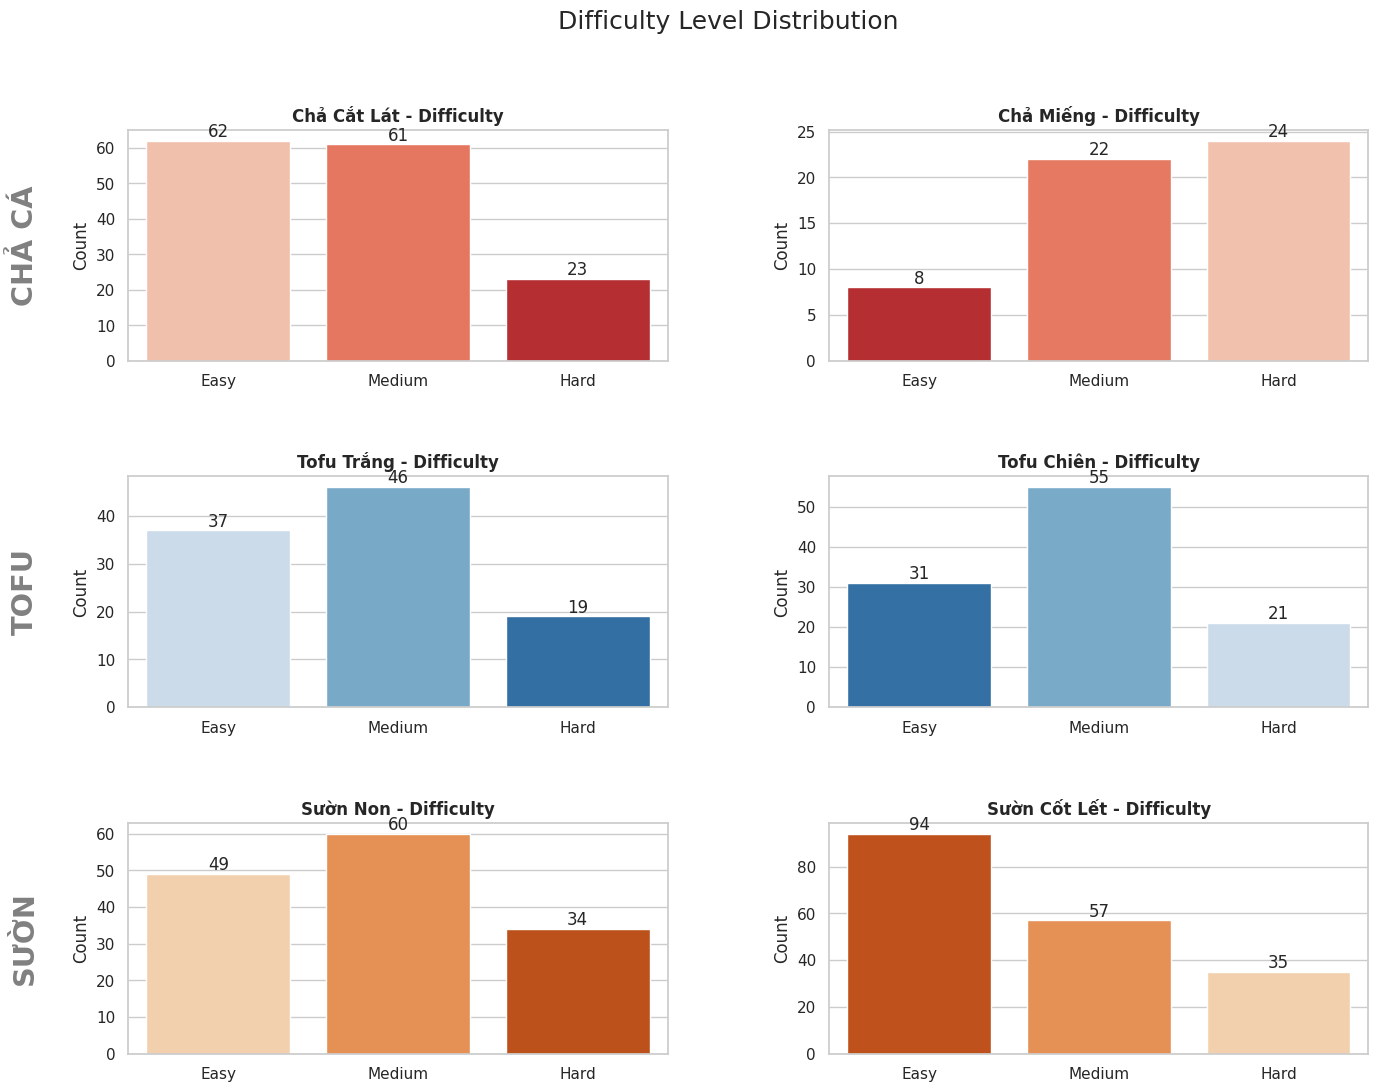

✅ Đã xuất ra 2 hình riêng biệt.


In [ ]:
def load_and_classify(file_path, dish_type):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"ERROR ({dish_type}): {e}")
        return pd.DataFrame()

    normalized_list = []

    for entry in data:
        food_attrs = entry.get('food_attributes', {})
        img_attrs = entry.get('image_attributes', {})

        sub_class = "Unknown"
        if dish_type == 'Cha Ca':
            texture = food_attrs.get('surface_texture', '')
            sub_class = 'cha_cat_lat' if texture == 'Porous_Inner' else 'cha_mieng'
        elif dish_type == 'Tofu':
            texture = food_attrs.get('surface_texture', '')
            sub_class = 'tofu_trang' if texture == 'Matte_Porous' else 'tofu_chien'
        elif dish_type == 'Suon':
            raw_morph = food_attrs.get('morphology', {})
            cat = raw_morph.get('category', '') if isinstance(raw_morph, dict) else ''
            sub_class = 'suon_non' if cat == 'Volumetric_Rib_Chunk' else 'suon_cot_let'

        row = {
            'Dataset': dish_type,
            'Sub_Class': sub_class,
            'Filename': entry.get('id_anh', 'Unknown'),
            'Difficulty': img_attrs.get('difficulty_level', 'Unknown')
        }

        raw_morph = food_attrs.get('morphology', 'Unknown')
        if dish_type == 'Suon' and isinstance(raw_morph, dict):
            row['Morphology'] = raw_morph.get('category', 'Unknown')
        else:
            row['Morphology'] = str(raw_morph)

        row['Texture'] = food_attrs.get('surface_texture', 'Unknown')

        if dish_type == 'Cha Ca': row['Specific_Context'] = food_attrs.get('interaction_state', 'Unknown')
        elif dish_type == 'Tofu': row['Specific_Context'] = food_attrs.get('dish_variant', 'Unknown')
        elif dish_type == 'Suon': row['Specific_Context'] = food_attrs.get('dish_context', 'Unknown')

        normalized_list.append(row)

    return pd.DataFrame(normalized_list)

path_chaca = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/cha_ca_v2_final_labeled_new.json'
path_tofu  = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/tofu_final_labeled_new.json'
path_suon  = '/content/drive/MyDrive/Data MetaData/left_out_cha_mieng/suon_v2_filter_final.json'

print("⏳ Đang xử lý dữ liệu...")
df_chaca = load_and_classify(path_chaca, 'Cha Ca')
df_tofu = load_and_classify(path_tofu, 'Tofu')
df_suon = load_and_classify(path_suon, 'Suon')

layout_config = [
    [
        {'df': df_chaca, 'sub': 'cha_cat_lat', 'title': 'Chả Cắt Lát', 'color': 'Reds'},
        {'df': df_chaca, 'sub': 'cha_mieng',   'title': 'Chả Miếng',   'color': 'Reds_r'}
    ],
    [
        {'df': df_tofu,  'sub': 'tofu_trang',  'title': 'Tofu Trắng',  'color': 'Blues'},
        {'df': df_tofu,  'sub': 'tofu_chien',  'title': 'Tofu Chiên',  'color': 'Blues_r'}
    ],
    [
        {'df': df_suon,  'sub': 'suon_non',    'title': 'Sườn Non',    'color': 'Oranges'},
        {'df': df_suon,  'sub': 'suon_cot_let','title': 'Sườn Cốt Lết','color': 'Oranges_r'}
    ]
]
main_dish_labels = ['CHẢ CÁ', 'TOFU', 'SƯỜN']

print("\n🎨 1. Đang vẽ biểu đồ thuộc tính vật lý (Morphology, Texture, Context)...")
fig1, axes1 = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for row_idx, row_configs in enumerate(layout_config):

    ax_left = axes1[row_idx, 0]
    ax_left.annotate(main_dish_labels[row_idx], xy=(0, 0.5), xytext=(-ax_left.yaxis.labelpad - 20, 0),
                     xycoords=ax_left.yaxis.label, textcoords='offset points',
                     size='xx-large', ha='right', va='center', fontweight='heavy', rotation=90, color='gray')

    for col_idx, config in enumerate(row_configs):
        ax = axes1[row_idx, col_idx]
        df_sub = config['df'][config['df']['Sub_Class'] == config['sub']]

        if df_sub.empty:
            ax.text(0.5, 0.5, "No Data", ha='center'); continue

        cols = ['Morphology', 'Texture', 'Specific_Context']
        df_melt = df_sub[cols].melt(var_name='Attribute', value_name='Value')
        df_melt = df_melt[df_melt['Value'] != 'Unknown']

        if not df_melt.empty:
            sns.countplot(data=df_melt, y='Value', hue='Attribute', ax=ax, dodge=False, palette=config['color'])
            ax.set_title(f"{config['title']}", fontweight='bold')
            ax.set_xlabel('Count')
            if col_idx == 1: ax.legend(loc='lower right')
            else: ax.get_legend().remove()

plt.suptitle('Physical Attributes Distribution', fontsize=18, y=0.95)
plt.savefig('chart_1_attributes.png', bbox_inches='tight')
plt.show()

print("\n🎨 2. Đang vẽ biểu đồ độ khó (Difficulty Level)...")
fig2, axes2 = plt.subplots(3, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

diff_order = ['Easy', 'Medium', 'Hard']

for row_idx, row_configs in enumerate(layout_config):
    ax_left = axes2[row_idx, 0]
    ax_left.annotate(main_dish_labels[row_idx], xy=(0, 0.5), xytext=(-ax_left.yaxis.labelpad - 20, 0),
                     xycoords=ax_left.yaxis.label, textcoords='offset points',
                     size='xx-large', ha='right', va='center', fontweight='heavy', rotation=90, color='gray')

    for col_idx, config in enumerate(row_configs):
        ax = axes2[row_idx, col_idx]
        df_sub = config['df'][config['df']['Sub_Class'] == config['sub']]

        if df_sub.empty:
            ax.text(0.5, 0.5, "No Data", ha='center'); continue

        df_diff = df_sub[df_sub['Difficulty'] != 'Unknown']

        if not df_diff.empty:
            sns.countplot(data=df_diff, x='Difficulty', ax=ax, order=diff_order, palette=config['color'])

            for container in ax.containers:
                ax.bar_label(container)

            ax.set_title(f"{config['title']} - Difficulty", fontweight='bold')
            ax.set_ylabel('Count')
            ax.set_xlabel('')
        else:
            ax.text(0.5, 0.5, "No Difficulty Info", ha='center')

plt.suptitle('Difficulty Level Distribution', fontsize=18, y=0.98)
plt.savefig('chart_2_difficulty.png', bbox_inches='tight')
plt.show()

print("Đã xuất ra 2 hình riêng biệt.")